In [ ]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
import sklearn
import tensorflow as tf
from keras import optimizers
from keras import regularizers
from keras import Model, Input
from keras.layers import Lambda, Dense, Concatenate, Dropout, Dot, Add, Multiply, BatchNormalization, ReLU, LayerNormalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras import metrics
import keras.backend as K
from keras.utils.vis_utils import plot_model
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model

# Load data

In [ ]:
!gdown --id 1ec4VD7xw6_VUNvIitCKSUsSXJ4MJbh7Y

Downloading...
From: https://drive.google.com/uc?id=1ec4VD7xw6_VUNvIitCKSUsSXJ4MJbh7Y
To: /content/ml-20m.zip
100% 926M/926M [00:03<00:00, 233MB/s]


In [ ]:
!unzip ml-20m.zip

Archive:  ml-20m.zip
replace ml-20m/filtered_ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
%cd ml-20m/

/content/ml-20m


In [ ]:
user_genome = np.load('user_genome.npy')
movie_genome = pd.read_csv('genome_scores_filtered.csv').relevance.values.reshape(-1,1128)
df_total = pd.read_csv('filtered_ratings.csv')
df_train = pd.read_csv('training_set_70.csv')
df_test = pd.read_csv('testing_set_10.csv')
df_valid = pd.read_csv('valid_set_20.csv')

In [ ]:
def reset_idx(df_total, df):
    df_new = df.copy()
    user = df_total.userId.unique().tolist() #list id của các user
    movie = df_total.sort_values(by='movieId').movieId.unique().tolist() #list id của các movie
    user_dict = dict(zip(user, list(range(len(user)))))
    movie_dict = dict(zip(movie, list(range(len(movie)))))
    df_new['userId'] = df_new['userId'].map(user_dict)
    df_new['movieId'] = df_new['movieId'].map(movie_dict)
    return df_new

In [ ]:
trainset = reset_idx(df_total,df_train).values
testset = reset_idx(df_total,df_test).values
validset = reset_idx(df_total,df_valid).values

# Xây dựng lại hàm fit_generator

In [ ]:
# Hàm tính RMSE 
def RMSE( y_true, y_pred):
    """
    Compute root mean square error
    :param y_true: the true output
    :param y_pred: the predicted output
    :return: root mean square error
    """
    in_range1 = tf.less(y_pred, 0.5)
    y_pred = tf.where(in_range1, tf.math.multiply(tf.ones_like(y_pred),0.5), y_pred) 
    in_range2 = tf.greater(y_pred, 5)
    y_pred = tf.where(in_range2, tf.math.multiply(tf.ones_like(y_pred),5), y_pred)

    e = tf.math.subtract(y_true, y_pred)
    se = tf.square(e)  
    mse = tf.reduce_sum(se) / tf.math.count_nonzero(y_true, dtype='float32') 
    rmse = tf.math.sqrt(mse)
    return rmse  # root mean square error

# Hàm tính MAE
def mae(y_true, y_pred):
    in_range1 = tf.less(y_pred, 0.5)
    y_pred = tf.where(in_range1, tf.math.multiply(tf.ones_like(y_pred),0.5), y_pred) 
    in_range2 = tf.greater(y_pred, 5)
    y_pred = tf.where(in_range2, tf.math.multiply(tf.ones_like(y_pred),5), y_pred)
  
    e = tf.math.subtract(y_true, y_pred)
    ae = tf.math.abs(e)
    mae = tf.reduce_sum(ae) / tf.math.count_nonzero(y_true, dtype=tf.float32)
    
    return mae

# 
def compute_batch_range( N, batch, batch_sz):
    """
    Compute batch range
    :param N: the number of observation ratings
    :param batch: the index of batch
    :param batch_sz: batch's size
    :return:
    """
    upper = np.min([N, (batch + 1) * batch_sz])
    lower = batch * batch_sz
    return lower, upper

# Tạo data, trả về batch cho user, movie và rating tương ứng
def create_data(user_genome, movie_genome, train):
    
    user = user_genome[train[:,0].astype('int')]
    movie = movie_genome[train[:,1].astype('int')]
    rating = train[:,2]
    return user, movie, rating 

# Hàm train_generator thực hiện train theo batch
def train_generator(train, user_genome, movie_genome, batch_sz): 
    """
    Generate batch samples. Use in  fit_generator() in Keras
    :param Xtrain: input matrix NxD
    :param batch_sz: batch's size
    :return: batch samples
    """
    while True:  # loop indefinitely. important!
        # global_mean = np.ones((batch_sz,1))*3.530205
        N = train.shape[0]
        n_batches = int(np.ceil(N / batch_sz))
        
        trainset= sklearn.utils.shuffle(train)  # affect rows

        for batch in range(n_batches):
            lower, upper = compute_batch_range(N, batch, batch_sz)
            trainset_batch = trainset[lower:upper, :]
            U, M, targets = create_data(user_genome, movie_genome, trainset_batch)
                
            yield ([U,M], targets)

# Hàm test_generator
def test_generator(test, user_genome, movie_genome, batch_sz): 
    """
    Generate batch samples. Use in  fit_generator() in Keras
    :param Xtrain: input matrix NxD
    :param batch_sz: batch's size
    :return: batch samples
    """
    while True:  # loop indefinitely. important!
        # global_mean = np.ones((batch_sz,1))*3.530205
        N = test.shape[0]
        n_batches = int(np.ceil(N / batch_sz))
       
        for batch in range(n_batches):
            lower, upper = compute_batch_range(N, batch, batch_sz)
            testset_batch = test[lower:upper, :]
            U,M, targets = create_data(user_genome, movie_genome, testset_batch)
                
            yield ([U,M], targets)

# Tuning Hyper-parameters

## Cấu trúc mô hình

### Mô hình 1

In [ ]:
#xay dung model
#user
u_inp = Input(shape=(1128,))
u1 = Dense(512, activation='relu')(u_inp)
u2 = Dense(256, activation='relu')(u1)
u = Model(inputs = u_inp, outputs = u2)

#movie
m_inp = Input(shape=(1128,))
m1 = Dense(512, activation='relu')(m_inp)
m2 = Dense(256, activation='relu')(m1)
m = Model(inputs = m_inp, outputs = m2)

#concatenate
concat = Concatenate(axis=1)([u2, m2])
x = Dense(units = 256, activation='relu') (concat)
x = Dense(units = 128, activation='relu') (x)

#output
out = Dense(units = 1, activation='relu') (x)
model1 = Model(inputs=[u_inp, m_inp], outputs = out)

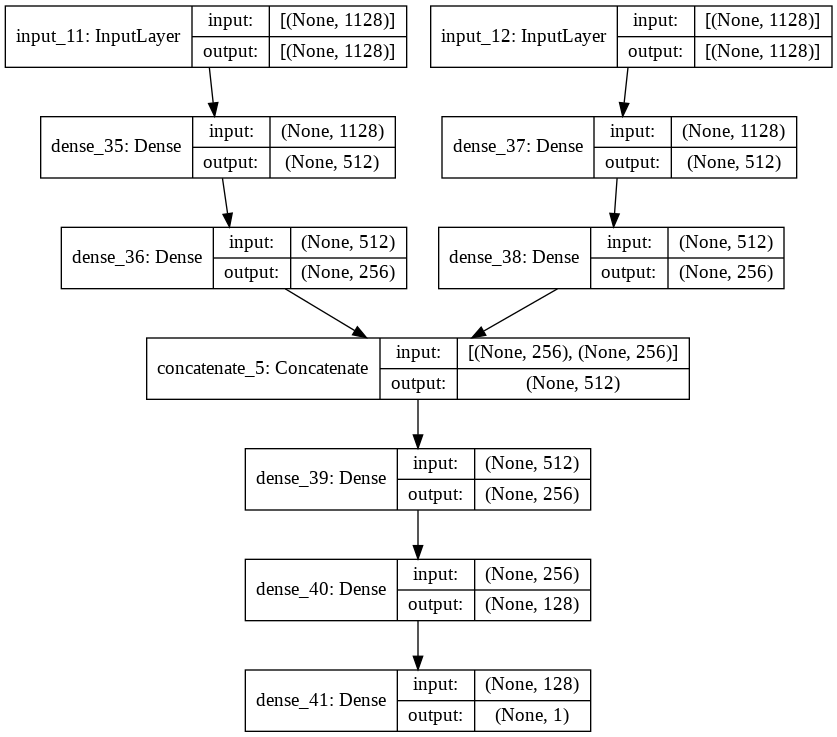

In [ ]:
plot_model(model1,  show_shapes=True, show_layer_names=True)

In [ ]:
batch_sz = 32768
epoch = 50
Ntrain,_ = trainset.shape
adam = tf.keras.optimizers.Adam(lr=0.001)
model1.compile(optimizer=adam, loss='mse', metrics=[RMSE])
# save_best, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint có loss thấp nhất 
save_best = ModelCheckpoint("model_checkpoint/best_project.hdf5", monitor='loss', 
                                verbose=1, save_best_only=True, mode='min', period=1)
# save_all, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint sau mỗi 5 epoch
save_all = ModelCheckpoint("model_checkpoint/all_project.hdf5", 
                                    verbose=1, period=5)
# reduce_lr, dùng để đưa vào callbacks cho hàm fit_generator, giảm learning rate nếu loss không giảm sau 10 epochs liên tiếp
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=10, verbose=1, mode="min", min_lr=0.00000001)
model1.fit_generator(generator=train_generator(trainset, user_genome, movie_genome, batch_sz), 
                        epochs=epoch,
                        steps_per_epoch=int(np.ceil(Ntrain / batch_sz)),
                        validation_data=test_generator(validset, user_genome, movie_genome, batch_sz),
                        validation_steps=int(np.ceil(testset.shape[0] / batch_sz)),
                        callbacks= [save_best, save_all, reduce_lr])

In [ ]:
# Lấy history của quá trình train
hist = model1.history.history

In [ ]:
# Đồ thị loss
plt.plot(np.arange(1,51,1), hist['loss'], label = 'train loss')
plt.plot(np.arange(1,51,1), hist['val_loss'], label = 'val loss')
plt.legend()
plt.show()

### Mô hình 2

In [ ]:
#xay dung model
#user
u_inp = Input(shape=(1128,))
u1 = Dense(512, activation='relu')(u_inp)
u2 = Dense(256, activation='relu')(u1)
u = Model(inputs = u_inp, outputs = u2)

#movie
m_inp = Input(shape=(1128,))
m1 = Dense(512, activation='relu')(m_inp)
m2 = Dense(256, activation='relu')(m1)
m = Model(inputs = m_inp, outputs = m2)

#concatenate
concat = Concatenate(axis=1)([u2, m2])
x = Dense(units = 256, activation='relu') (concat)

#output
out = Dense(units = 1, activation='relu') (x)
model2 = Model(inputs=[u_inp, m_inp], outputs = out)

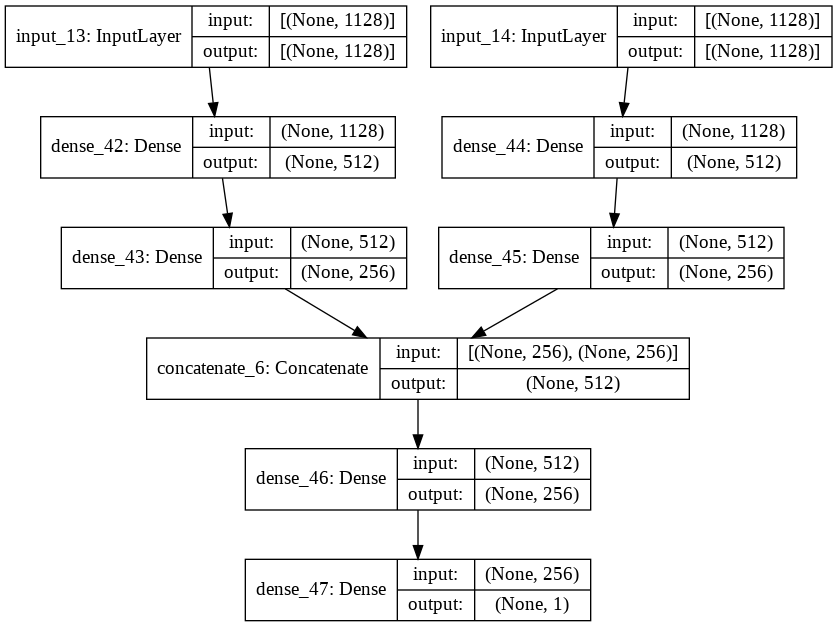

In [ ]:
plot_model(model2,  show_shapes=True, show_layer_names=True)

In [ ]:
batch_sz = 32768
epoch = 50
Ntrain,_ = trainset.shape
adam = tf.keras.optimizers.Adam(lr=0.001)
model2.compile(optimizer=adam, loss='mse', metrics=[RMSE])
# save_best, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint có loss thấp nhất 
save_best = ModelCheckpoint("model_checkpoint/best_project.hdf5", monitor='loss', 
                                verbose=1, save_best_only=True, mode='min', period=1)
# save_all, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint sau mỗi 5 epoch
save_all = ModelCheckpoint("model_checkpoint/all_project.hdf5", 
                                    verbose=1, period=5)
# reduce_lr, dùng để đưa vào callbacks cho hàm fit_generator, giảm learning rate nếu loss không giảm sau 10 epochs liên tiếp
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=10, verbose=1, mode="min", min_lr=0.00000001)
model2.fit_generator(generator=train_generator(trainset, user_genome, movie_genome, batch_sz), 
                        epochs=epoch,
                        steps_per_epoch=int(np.ceil(Ntrain / batch_sz)),
                        validation_data=test_generator(validset, user_genome, movie_genome, batch_sz),
                        validation_steps=int(np.ceil(testset.shape[0] / batch_sz)),
                        callbacks= [save_best, save_all, reduce_lr])

In [ ]:
# Lấy history của quá trình train
hist = model2.history.history

In [ ]:
# Đồ thị loss
plt.plot(np.arange(1,51,1), hist['loss'], label = 'train loss')
plt.plot(np.arange(1,51,1), hist['val_loss'], label = 'val loss')
plt.legend()
plt.show()

### Mô hình 3

In [ ]:
#xay dung model
#user
u_inp = Input(shape=(1128,))
u1 = Dense(512, activation='relu')(u_inp)
u = Model(inputs = u_inp, outputs = u1)

#movie
m_inp = Input(shape=(1128,))
m1 = Dense(512, activation='relu')(m_inp)
m = Model(inputs = m_inp, outputs = m1)

#concatenate
concat = Concatenate(axis=1)([u1, m1])
x = Dense(units = 512, activation='relu') (concat)
x = Dense(units = 256, activation='relu') (x)

#output
out = Dense(units = 1, activation='relu') (x)
model3 = Model(inputs=[u_inp, m_inp], outputs = out)

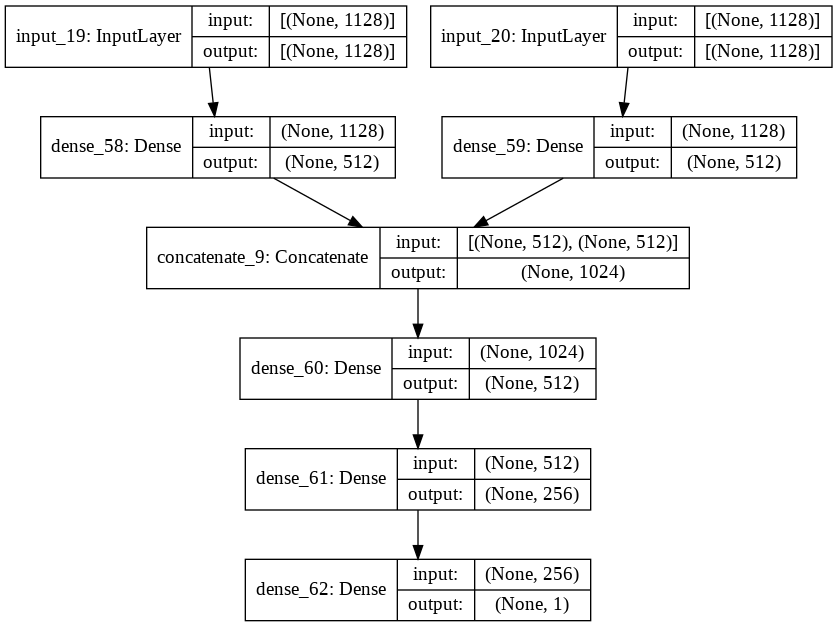

In [ ]:
plot_model(model3,  show_shapes=True, show_layer_names=True)

In [ ]:
batch_sz = 32768
epoch = 50
Ntrain,_ = trainset.shape
adam = tf.keras.optimizers.Adam(lr=0.001)
model3.compile(optimizer=adam, loss='mse', metrics=[RMSE])
# save_best, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint có loss thấp nhất 
save_best = ModelCheckpoint("model_checkpoint/best_project.hdf5", monitor='loss', 
                                verbose=1, save_best_only=True, mode='min', period=1)
# save_all, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint sau mỗi 5 epoch
save_all = ModelCheckpoint("model_checkpoint/all_project.hdf5", 
                                    verbose=1, period=5)
# reduce_lr, dùng để đưa vào callbacks cho hàm fit_generator, giảm learning rate nếu loss không giảm sau 10 epochs liên tiếp
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=10, verbose=1, mode="min", min_lr=0.00000001)
model3.fit_generator(generator=train_generator(trainset, user_genome, movie_genome, batch_sz), 
                        epochs=epoch,
                        steps_per_epoch=int(np.ceil(Ntrain / batch_sz)),
                        validation_data=test_generator(validset, user_genome, movie_genome, batch_sz),
                        validation_steps=int(np.ceil(testset.shape[0] / batch_sz)),
                        callbacks= [save_best, save_all, reduce_lr])

In [ ]:
# Lấy history của quá trình train
hist = model3.history.history

In [ ]:
# Đồ thị loss
plt.plot(np.arange(1,51,1), hist['loss'], label = 'train loss')
plt.plot(np.arange(1,51,1), hist['val_loss'], label = 'val loss')
plt.legend()
plt.show()

## Regularization

### Batchsize 32768

In [ ]:
#xay dung model
#user
u_inp = Input(shape=(1128,))
u1 = Dense(512, activation='relu')(u_inp)
u = Model(inputs = u_inp, outputs = u1)

#movie
m_inp = Input(shape=(1128,))
m1 = Dense(512, activation='relu')(m_inp)
m = Model(inputs = m_inp, outputs = m1)

#concatenate
concat = Concatenate(axis=1)([u1, m1])
x = BatchNormalization()(concat)
x = Dense(units = 512, activation='relu') (x)
x = Dense(units = 256, activation='relu') (x)

#output
out = Dense(units = 1, activation='relu') (x)
model4 = Model(inputs=[u_inp, m_inp], outputs = out)

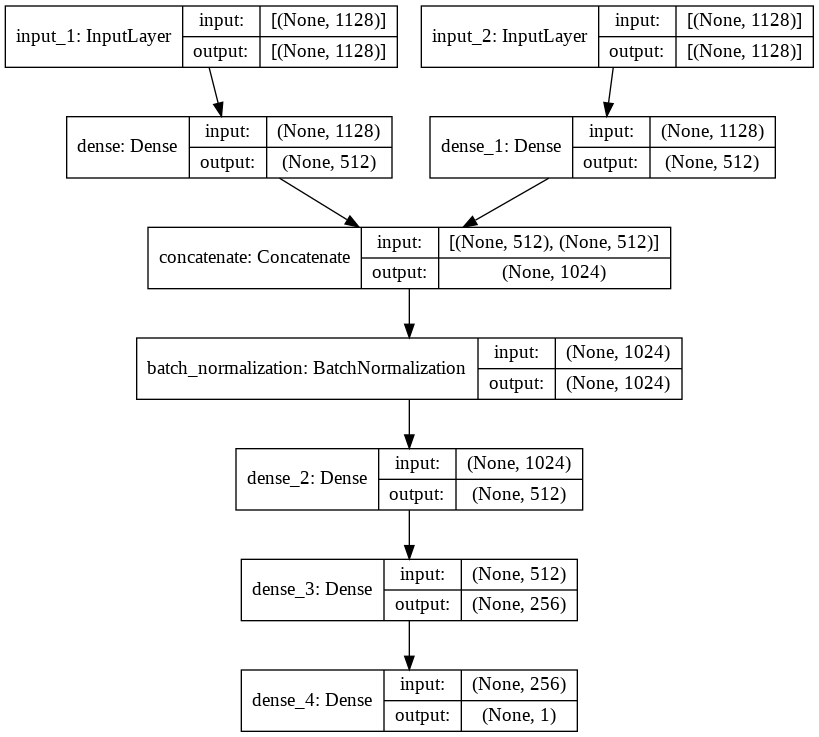

In [ ]:
plot_model(model4,  show_shapes=True, show_layer_names=True)

In [ ]:
# Cài đặt batchsize, dùng để truyền vào hàm fit_generator
batch_sz = 32768
epoch = 50
Ntrain,_ = trainset.shape
adam = tf.keras.optimizers.Adam(lr=0.001)
model4.compile(optimizer=adam, loss='mse', metrics=[RMSE])
# save_best, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint có loss thấp nhất 
save_best = ModelCheckpoint("model_checkpoint/best_project.hdf5", monitor='loss', 
                                verbose=1, save_best_only=True, mode='min', period=1)
# save_all, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint sau mỗi 5 epoch
save_all = ModelCheckpoint("model_checkpoint/all_project.hdf5", 
                                    verbose=1, period=5)
# reduce_lr, dùng để đưa vào callbacks cho hàm fit_generator, giảm learning rate nếu loss không giảm sau 10 epochs liên tiếp
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=10, verbose=1, mode="min", min_lr=0.00000001)
model4.fit_generator(generator=train_generator(trainset, user_genome, movie_genome, batch_sz), 
                        epochs=epoch,
                        steps_per_epoch=int(np.ceil(Ntrain / batch_sz)),
                        validation_data=test_generator(validset, user_genome, movie_genome, batch_sz),
                        validation_steps=int(np.ceil(testset.shape[0] / batch_sz)),
                        callbacks= [save_best, save_all, reduce_lr])

In [ ]:
# Lấy history của quá trình train
hist = model4.history.history

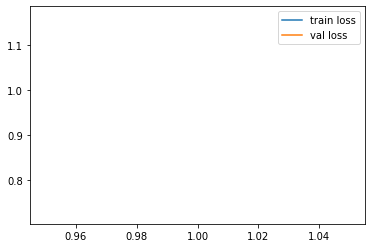

In [ ]:
# Đồ thị loss
plt.plot(np.arange(1,51,1), hist['loss'], label = 'train loss')
plt.plot(np.arange(1,51,1), hist['val_loss'], label = 'val loss')
plt.legend()
plt.show()

### Batchsize 65536

In [ ]:
# Cài đặt batchsize, dùng để truyền vào hàm fit_generator
batch_sz = 65534
epoch = 50
Ntrain,_ = trainset.shape
adam = tf.keras.optimizers.Adam(lr=0.001)
model4.compile(optimizer=adam, loss='mse', metrics=[RMSE])
# save_best, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint có loss thấp nhất 
save_best = ModelCheckpoint("model_checkpoint/best_project.hdf5", monitor='loss', 
                                verbose=1, save_best_only=True, mode='min', period=1)
# save_all, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint sau mỗi 5 epoch
save_all = ModelCheckpoint("model_checkpoint/all_project.hdf5", 
                                    verbose=1, period=5)
# reduce_lr, dùng để đưa vào callbacks cho hàm fit_generator, giảm learning rate nếu loss không giảm sau 10 epochs liên tiếp
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=10, verbose=1, mode="min", min_lr=0.00000001)
model4.fit_generator(generator=train_generator(trainset, user_genome, movie_genome, batch_sz), 
                        epochs=epoch,
                        steps_per_epoch=int(np.ceil(Ntrain / batch_sz)),
                        validation_data=test_generator(validset, user_genome, movie_genome, batch_sz),
                        validation_steps=int(np.ceil(testset.shape[0] / batch_sz)),
                        callbacks= [save_best, save_all, reduce_lr])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


212/212 [==============================] - 97s 454ms/step - loss: 0.6933 - RMSE: 0.8234 - val_loss: 0.7782 - val_RMSE: 0.8821

Epoch 00001: loss improved from inf to 0.69326, saving model to model_checkpoint/best_project.hdf5


In [ ]:
# Lấy history của quá trình train
hist = model4.history.history

In [ ]:
# Đồ thị loss
plt.plot(np.arange(1,51,1), hist['loss'], label = 'train loss')
plt.plot(np.arange(1,51,1), hist['val_loss'], label = 'val loss')
plt.legend()
plt.show()

### L2 Regularization, $\lambda = 0.01$

In [ ]:
#xay dung model
#user
u_inp = Input(shape=(1128,))
u1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(u_inp)
u = Model(inputs = u_inp, outputs = u1)

#movie
m_inp = Input(shape=(1128,))
m1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(m_inp)
m = Model(inputs = m_inp, outputs = m1)

#concatenate
concat = Concatenate(axis=1)([u1, m1])
x = BatchNormalization()(concat)
x = Dense(units = 512, activation='relu', kernel_regularizer=regularizers.l2(0.01)) (x)
x = Dense(units = 256, activation='relu', kernel_regularizer=regularizers.l2(0.01)) (x)
#output
out = Dense(units = 1, activation='relu', kernel_regularizer=regularizers.l2(0.01)) (x)
model5 = Model(inputs=[u_inp, m_inp], outputs = out)

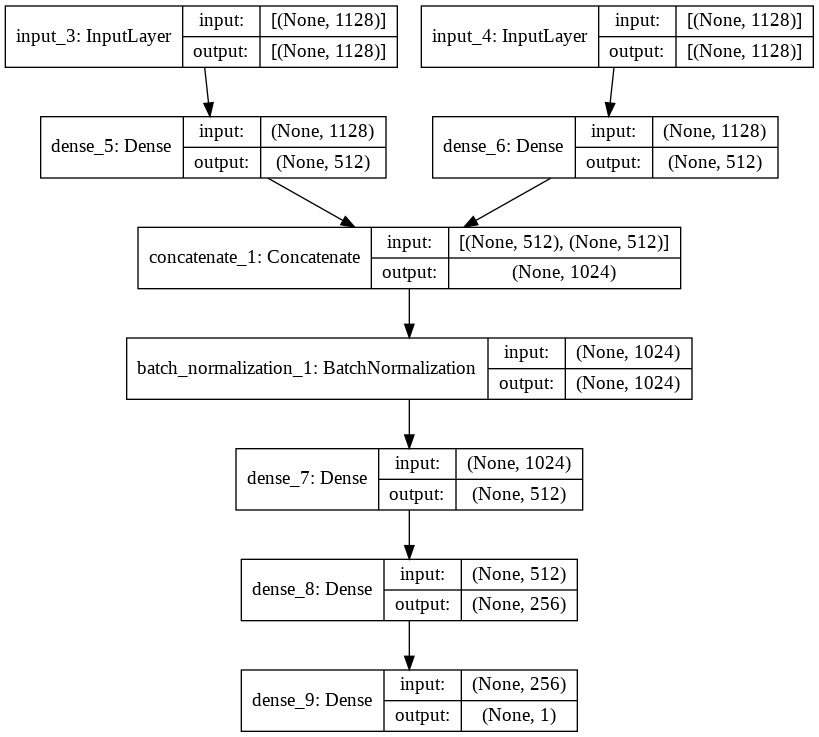

In [ ]:
plot_model(model5,  show_shapes=True, show_layer_names=True)

In [ ]:
# Cài đặt batchsize, dùng để truyền vào hàm fit_generator
batch_sz = 32768
epoch = 50
Ntrain,_ = trainset.shape
adam = tf.keras.optimizers.Adam(lr=0.001)
model5.compile(optimizer=adam, loss='mse', metrics=[RMSE])
# save_best, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint có loss thấp nhất 
save_best = ModelCheckpoint("model_checkpoint/best_project.hdf5", monitor='loss', 
                                verbose=1, save_best_only=True, mode='min', period=1)
# save_all, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint sau mỗi 5 epoch
save_all = ModelCheckpoint("model_checkpoint/all_project.hdf5", 
                                    verbose=1, period=5)
# reduce_lr, dùng để đưa vào callbacks cho hàm fit_generator, giảm learning rate nếu loss không giảm sau 10 epochs liên tiếp
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=10, verbose=1, mode="min", min_lr=0.00000001)
model5.fit_generator(generator=train_generator(trainset, user_genome, movie_genome, batch_sz), 
                        epochs=epoch,
                        steps_per_epoch=int(np.ceil(Ntrain / batch_sz)),
                        validation_data=test_generator(validset, user_genome, movie_genome, batch_sz),
                        validation_steps=int(np.ceil(testset.shape[0] / batch_sz)),
                        callbacks= [save_best, save_all, reduce_lr])

In [ ]:
# Lấy history của quá trình train
hist = model5.history.history

In [ ]:
# Đồ thị loss
plt.plot(np.arange(1,51,1), hist['loss'], label = 'train loss')
plt.plot(np.arange(1,51,1), hist['val_loss'], label = 'val loss')
plt.legend()
plt.show()

### L2 Regularization, $\lambda = 0.001$

In [ ]:
#xay dung model
#user
u_inp = Input(shape=(1128,))
u1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(u_inp)
u = Model(inputs = u_inp, outputs = u1)

#movie
m_inp = Input(shape=(1128,))
m1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(m_inp)
m = Model(inputs = m_inp, outputs = m1)

#concatenate
concat = Concatenate(axis=1)([u1, m1])
x = BatchNormalization()(concat)
x = Dense(units = 512, activation='relu', kernel_regularizer=regularizers.l2(0.001)) (x)
x = Dense(units = 256, activation='relu', kernel_regularizer=regularizers.l2(0.001)) (x)
#output
out = Dense(units = 1, activation='relu', kernel_regularizer=regularizers.l2(0.001)) (x)
model6 = Model(inputs=[u_inp, m_inp], outputs = out)

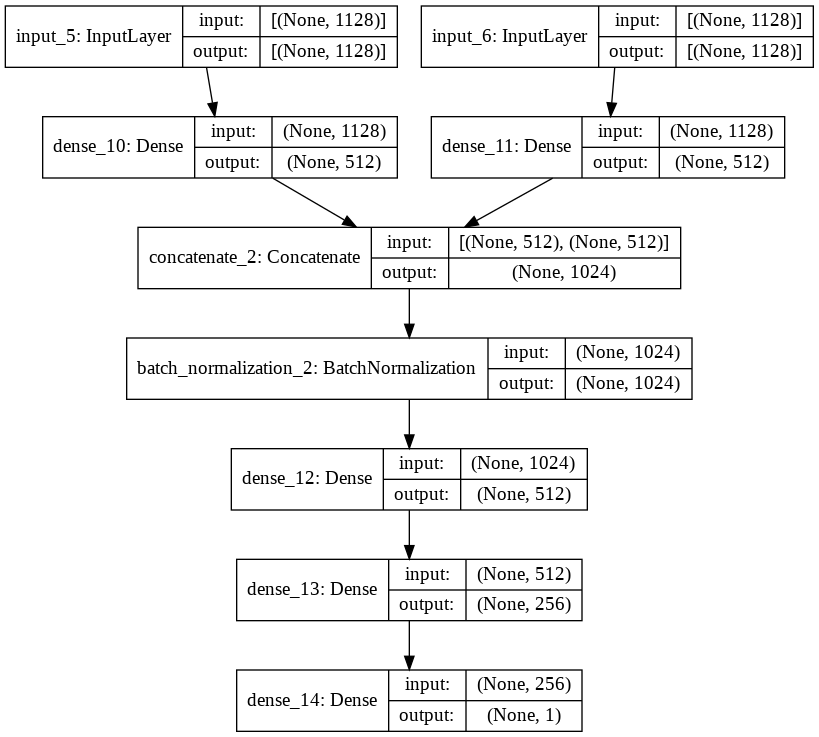

In [ ]:
plot_model(model6,  show_shapes=True, show_layer_names=True)

In [ ]:
# Cài đặt batchsize, dùng để truyền vào hàm fit_generator
batch_sz = 32768
epoch = 50
Ntrain,_ = trainset.shape
adam = tf.keras.optimizers.Adam(lr=0.001)
model6.compile(optimizer=adam, loss='mse', metrics=[RMSE])
# save_best, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint có loss thấp nhất 
save_best = ModelCheckpoint("model_checkpoint/best_project.hdf5", monitor='loss', 
                                verbose=1, save_best_only=True, mode='min', period=1)
# save_all, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint sau mỗi 5 epoch
save_all = ModelCheckpoint("model_checkpoint/all_project.hdf5", 
                                    verbose=1, period=5)
# reduce_lr, dùng để đưa vào callbacks cho hàm fit_generator, giảm learning rate nếu loss không giảm sau 10 epochs liên tiếp
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=10, verbose=1, mode="min", min_lr=0.00000001)
model6.fit_generator(generator=train_generator(trainset, user_genome, movie_genome, batch_sz), 
                        epochs=epoch,
                        steps_per_epoch=int(np.ceil(Ntrain / batch_sz)),
                        validation_data=test_generator(validset, user_genome, movie_genome, batch_sz),
                        validation_steps=int(np.ceil(testset.shape[0] / batch_sz)),
                        callbacks= [save_best, save_all, reduce_lr])

In [ ]:
# Lấy history của quá trình train
hist = model6.history.history

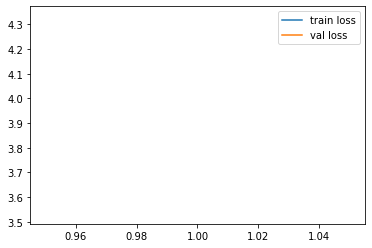

In [ ]:
# Đồ thị loss
plt.plot(np.arange(1,51,1), hist['loss'], label = 'train loss')
plt.plot(np.arange(1,51,1), hist['val_loss'], label = 'val loss')
plt.legend()
plt.show()

## Chiến lược thay đổi learning rate

### Constance learning rate

In [ ]:
#xay dung model
#user
u_inp = Input(shape=(1128,))
u1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(u_inp)
u = Model(inputs = u_inp, outputs = u1)

#movie
m_inp = Input(shape=(1128,))
m1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(m_inp)
m = Model(inputs = m_inp, outputs = m1)

#concatenate
concat = Concatenate(axis=1)([u1, m1])
x = BatchNormalization()(concat)
x = Dense(units = 512, activation='relu', kernel_regularizer=regularizers.l2(0.01)) (x)
x = Dense(units = 256, activation='relu', kernel_regularizer=regularizers.l2(0.01)) (x)
#output
out = Dense(units = 1, activation='relu', kernel_regularizer=regularizers.l2(0.01)) (x)
model7 = Model(inputs=[u_inp, m_inp], outputs = out)

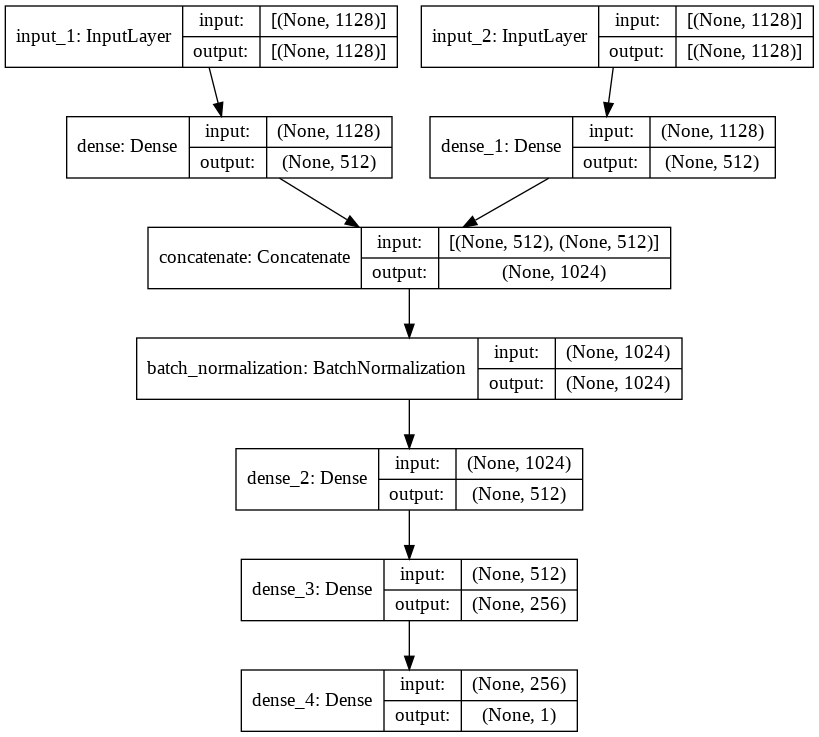

In [ ]:
plot_model(model7,  show_shapes=True, show_layer_names=True)

In [ ]:
# Cài đặt batchsize, dùng để truyền vào hàm fit_generator
batch_sz = 32768
epoch = 50
Ntrain,_ = trainset.shape
adam = tf.keras.optimizers.Adam(lr=0.001)
model7.compile(optimizer=adam, loss='mse', metrics=[RMSE])
# save_best, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint có loss thấp nhất 
save_best = ModelCheckpoint("model_checkpoint/best_project.hdf5", monitor='loss', 
                                verbose=1, save_best_only=True, mode='min', period=1)
# save_all, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint sau mỗi 5 epoch
save_all = ModelCheckpoint("model_checkpoint/all_project.hdf5", 
                                    verbose=1, period=5)
# Constance learning rate
def cons_lr_func(epoch, lr):
    return 0.001
cons_lr = keras.callbacks.LearningRateScheduler(cons_lr_func)
model7.fit_generator(generator=train_generator(trainset, user_genome, movie_genome, batch_sz), 
                        epochs=epoch,
                        steps_per_epoch=int(np.ceil(Ntrain / batch_sz)),
                        validation_data=test_generator(validset, user_genome, movie_genome, batch_sz),
                        validation_steps=int(np.ceil(testset.shape[0] / batch_sz)),
                        callbacks= [save_best, save_all, cons_lr])

In [ ]:
# Lấy history của quá trình train
hist = model7.history.history

In [ ]:
# Đồ thị loss
plt.plot(np.arange(1,51,1), hist['loss'], label = 'train loss')
plt.plot(np.arange(1,51,1), hist['val_loss'], label = 'val loss')
plt.legend()
plt.show()

### ReduceLROnPlateau

In [ ]:
# Cài đặt batchsize, dùng để truyền vào hàm fit_generator
batch_sz = 32768
epoch = 50
Ntrain,_ = trainset.shape
adam = tf.keras.optimizers.Adam(lr=0.001)
model7.compile(optimizer=adam, loss='mse', metrics=[RMSE])
# save_best, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint có loss thấp nhất 
save_best = ModelCheckpoint("model_checkpoint/best_project.hdf5", monitor='loss', 
                                verbose=1, save_best_only=True, mode='min', period=1)
# save_all, dùng để đưa vào callbacks cho hàm fit_generator, lưu lại checkpoint sau mỗi 5 epoch
save_all = ModelCheckpoint("model_checkpoint/all_project.hdf5", 
                                    verbose=1, period=5)
# reduce_lr, sau 10 epoch nếu loss không giảm thì giảm learning rate 10 lần
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=10, verbose=1, mode="min", min_lr=0.00000001)
model7.fit_generator(generator=train_generator(trainset, user_genome, movie_genome, batch_sz), 
                        epochs=epoch,
                        steps_per_epoch=int(np.ceil(Ntrain / batch_sz)),
                        validation_data=test_generator(validset, user_genome, movie_genome, batch_sz),
                        validation_steps=int(np.ceil(testset.shape[0] / batch_sz)),
                        callbacks= [save_best, save_all, reduce_lr])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


423/423 [==============================] - 98s 230ms/step - loss: 0.7447 - RMSE: 0.8265 - val_loss: 0.7476 - val_RMSE: 0.8383

Epoch 00001: loss improved from inf to 0.74466, saving model to model_checkpoint/best_project.hdf5


In [ ]:
# Lấy history của quá trình train
hist = model7.history.history

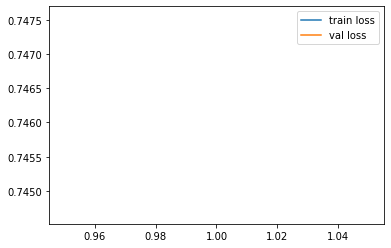

In [ ]:
# Đồ thị loss
plt.plot(np.arange(1,51,1), hist['loss'], label = 'train loss')
plt.plot(np.arange(1,51,1), hist['val_loss'], label = 'val loss')
plt.legend()
plt.show()

### Cosine warmup 

In [ ]:
# cosine warmup 
# ref: https://github.com/Tony607/Keras_Bag_of_Tricks.git
def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    """Cosine decay schedule with warm up period.
    Cosine annealing learning rate as described in:
      Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
      ICLR 2017. https://arxiv.org/abs/1608.03983
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.
    Arguments:
        global_step {int} -- global step.
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.
    Keyword Arguments:
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
    Returns:
      a float representing learning rate.
    Raises:
      ValueError: if warmup_learning_rate is larger than learning_rate_base,
        or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to '
                         'warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to '
                             'warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(keras.callbacks.Callback):
    """Cosine decay with warmup learning rate scheduler
    """

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """Constructor for cosine decay with warmup learning rate scheduler.
    Arguments:
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.
    Keyword Arguments:
        global_step_init {int} -- initial global step, e.g. from previous checkpoint.
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
        verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr))

# Huấn luyện mô hình hoàn chỉnh trên tập train và valid, đánh giá trực tiếp trên tập test

In [ ]:
user_genome = np.load('user_genome.npy')
movie_genome = pd.read_csv('genome_scores_filtered.csv').relevance.values.reshape(-1,1128)
df_total = pd.read_csv('filtered_ratings.csv')
df_train = pd.read_csv('training_set_70.csv')
df_test = pd.read_csv('testing_set_10.csv')
df_valid = pd.read_csv('valid_set_20.csv')

In [ ]:
df_train_final = pd.concat([df_train, df_valid])
del df_train, df_valid

In [ ]:
def reset_idx(df_total, df):
    df_new = df.copy()
    user = df_total.sort_values(by='userId').userId.unique().tolist() #list id của các user
    movie = df_total.sort_values(by='movieId').movieId.unique().tolist() #list id của các movie
    user_dict = dict(zip(user, list(range(len(user)))))
    movie_dict = dict(zip(movie, list(range(len(movie)))))
    df_new['userId'] = df_new['userId'].map(user_dict)
    df_new['movieId'] = df_new['movieId'].map(movie_dict)
    return df_new

In [ ]:
trainset = reset_idx(df_total,df_train_final).values
testset = reset_idx(df_total,df_test).values

In [ ]:
#xay dung model
#user
u_inp = Input(shape=(1128,))
u1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(u_inp)
u = Model(inputs = u_inp, outputs = u1)

#movie
m_inp = Input(shape=(1128,))
m1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(m_inp)
m = Model(inputs = m_inp, outputs = m1)

#concatenate
concat = Concatenate(axis=1)([u1, m1])
x = BatchNormalization()(concat)
x = Dense(units = 512, activation='relu', kernel_regularizer=regularizers.l2(0.01)) (x)
x = Dense(units = 256, activation='relu', kernel_regularizer=regularizers.l2(0.01)) (x)
#output
out = Dense(units = 1, activation='relu', kernel_regularizer=regularizers.l2(0.01)) (x)
model = Model(inputs=[u_inp, m_inp], outputs = out)

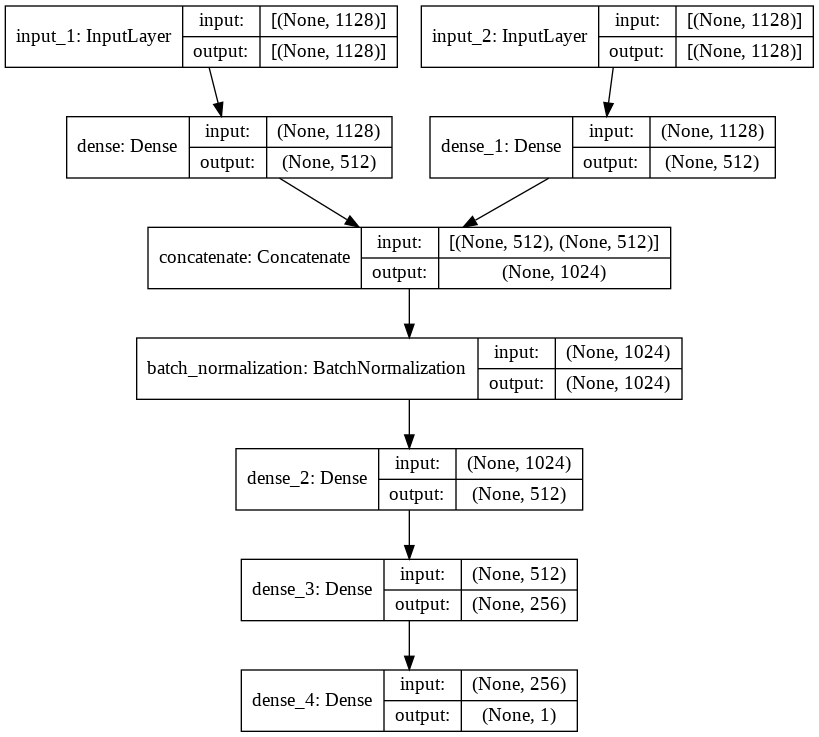

In [ ]:
plot_model(model,  show_shapes=True, show_layer_names=True)

In [ ]:
batch_sz = 32768
epoch = 50
Ntrain,_ = trainset.shape
# Cosine warmup learning rate
lr = WarmUpCosineDecayScheduler(learning_rate_base=0.001,
                                            total_steps=epoch*int(np.ceil(Ntrain / batch_sz)),
                                            warmup_learning_rate=0.0,
                                            warmup_steps=int(10 * int(np.ceil(Ntrain / batch_sz))),
                                            hold_base_rate_steps=0)
adam = tf.keras.optimizers.Adam(learning_rate = 0.001) 
model.compile(optimizer=adam, loss='mse', metrics=[RMSE, mae])    
save_best = ModelCheckpoint("model_checkpoint/best_project_CNMFcosine_warmup.hdf5", monitor='val_RMSE', 
                                verbose=1, save_best_only=True, mode='min', period=1)
save_all = save_all = ModelCheckpoint("model_checkpoint/all_project_CNMF_cosine_warmup.hdf5", 
                                    verbose=1, period=5)
history = model.fit_generator(generator=train_generator(trainset, user_genome, movie_genome, batch_sz), 
                        epochs=epoch,
                        steps_per_epoch=int(np.ceil(Ntrain / batch_sz)),
                        validation_data=test_generator(testset, user_genome, movie_genome, batch_sz),
                        validation_steps=int(np.ceil(testset.shape[0] / batch_sz)),
                        callbacks= [save_best, save_all, lr])


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/11
423/423 [==============================] - 100s 235ms/step - loss: 0.7055 - RMSE: 0.8132 - mae: 0.6255 - val_loss: 0.7266 - val_RMSE: 0.8261 - val_mae: 0.6338

Epoch 00001: val_RMSE improved from inf to 0.82615, saving model to model_checkpoint/best_project_CNMFcosine_warmup.hdf5
Epoch 2/11
423/423 [==============================] - 104s 247ms/step - loss: 0.7047 - RMSE: 0.8125 - mae: 0.6250 - val_loss: 0.7370 - val_RMSE: 0.8321 - val_mae: 0.6329

Epoch 00002: val_RMSE did not improve from 0.82615
Epoch 3/11
423/423 [==============================] - 105s 248ms/step - loss: 0.7045 - RMSE: 0.8126 - mae: 0.6251 - val_loss: 0.7254 - val_RMSE: 0.8257 - val_mae: 0.6363

Epoch 00003: val_RMSE improved from 0.82615 to 0.82567, saving model to model_checkpoint/best_project_CNMFcosine_warmup.hdf5
Epoch 4/11
423/423 [==============================] - 105s 248ms/step - loss: 0.7044 - RMSE: 0.8131 - mae: 0.6255 - val_loss: 0.7444 - val_RMSE: 0.8376 - val_mae: 0.6509

Epoch 00004: val_RM

In [ ]:
# Lấy history của quá trình train
hist = model7.history.history

In [ ]:
# Đồ thị loss
plt.plot(np.arange(1,51,1), hist['loss'], label = 'train loss')
plt.plot(np.arange(1,51,1), hist['val_loss'], label = 'val loss')
plt.legend()
plt.show()